In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
! rsync --progress "bluemoon-user1.uvm.edu:thesis/data/0.365-0.656.pkl" "../../data/0.365-0.656.pkl"

0.365-0.656.pkl
  2731038005 100%    7.04MB/s    0:06:09 (xfer#1, to-check=0/1)

sent 38 bytes  received 2731704865 bytes  7373022.68 bytes/sec
total size is 2731038005  speedup is 1.00


In [3]:
%%time
with open("../../data/0.365-0.656.pkl", "rb") as f:
    params, sol, phase, χ, m = pickle.load(f)

CPU times: user 1.73 s, sys: 8.07 s, total: 9.8 s
Wall time: 21.9 s


In [4]:
phase.max()/(np.pi*2)

0.9999999989047382

In [5]:
χ

0.07185282534973242

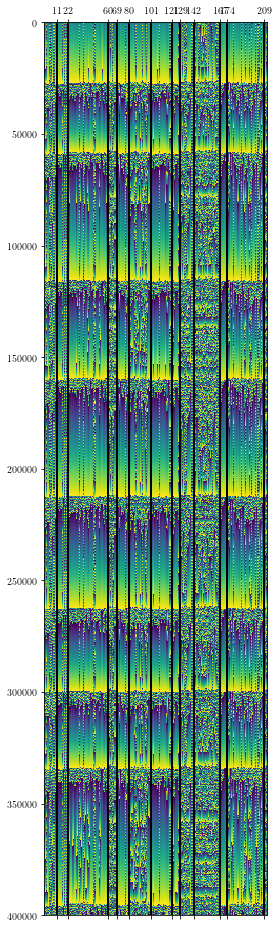

In [6]:
plt.matshow(phase,aspect="auto")
ax = plt.gca()
ax.set_xticks([11.5, 22.5, 60.5, 69.5, 80.5, 101.5, 121.5, 129.5, 142.5, 167.5, 174.5, 209.5])
ax.set_xticklabels([11, 22, 60, 69, 80, 101, 121, 129, 142, 167, 174, 209])
plt.grid(axis="x", linewidth=2, color="k")